In [107]:
# Module imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.colors as mcolors
import numpy as np
import json

# Imports from individual codebase
from fpl_data_retrieval import get_fpl_data, get_current_gameweek
from basic_set_and_forget_optimisation import simulate_model_team

In [108]:
# Define a year to run the analysis on and enter own ID for the season
year = '2023-2024'
own_team_id = 973

# Load the team dataframe
team_df = pd.read_csv('optimal_teams/set_and_forget_' + year + '.csv')
display(team_df)

,id,web_name,positions,now_cost,start_cost,short_name,total_points,gw_1_points,gw_1_minutes,gw_2_points,...,gw_36_points,gw_36_minutes,gw_37_points,gw_37_minutes,gw_38_points,gw_38_minutes,in_lineup,on_bench,is_captain,is_vice_captain
0,263,Pickford,GK,48,45,EVE,153,2,90,0,...,3,90,8,90,1,90,True,False,False,False
1,20,Saliba,DEF,59,50,ARS,164,5,90,8,...,6,90,9,90,2,90,True,False,False,False
2,29,White,DEF,61,55,ARS,182,1,90,7,...,6,90,6,90,2,68,True,False,False,False
3,506,Pedro Porro,DEF,59,50,TOT,136,0,0,6,...,0,90,10,180,14,75,True,False,False,False
4,362,Palmer,MID,63,50,CHE,244,1,10,0,...,8,88,14,180,6,88,True,False,True,False
5,353,Foden,MID,85,75,MCI,230,3,90,9,...,5,79,11,171,15,90,True,False,False,True
6,412,Gordon,MID,64,55,NEW,183,4,67,0,...,6,84,8,180,0,0,True,False,False,False
7,516,Son,MID,100,90,TOT,213,2,74,3,...,7,90,4,180,7,87,True,False,False,False
8,19,Saka,MID,88,85,ARS,226,10,90,3,...,10,85,2,81,0,0,True,False,False,False
9,60,Watkins,FWD,89,80,AVL,228,5,90,5,...,2,90,5,90,2,68,True,False,False,False


In [109]:
# Simulate the season (function in basic_set_and_forget_optimisation.py)
simulated_team_season = simulate_model_team(team_df)
print(simulated_team_season)

total_points = 0
for gameweek_data in simulated_team_season:
    for _, gameweek_info in gameweek_data.items():
        total_points += gameweek_info['points']

print("Total points:", total_points)

[{1: {'points': 48, 'subs_made': [{'sub_out': 506, 'sub_in': 616}], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {2: {'points': 57, 'subs_made': [{'sub_out': 362, 'sub_in': 85}], 'did_captain_play': False, 'vice_play_in_captains_place': True}}, {3: {'points': 49, 'subs_made': [{'sub_out': 362, 'sub_in': 245}], 'did_captain_play': False, 'vice_play_in_captains_place': True}}, {4: {'points': 63, 'subs_made': [], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {5: {'points': 46, 'subs_made': [], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {6: {'points': 75, 'subs_made': [], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {7: {'points': 86, 'subs_made': [], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {8: {'points': 74, 'subs_made': [{'sub_out': 412, 'sub_in': 245}, {'sub_out': 19, 'sub_in': 85}], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {9: {'points': 69, 'subs_made

In [110]:
def convert_history_to_df(df, history):
    """
    Converts the match history including substitutions to a single dataframe.

    Args:
        df (pd.DataFrame): The dataframe containing the baseline player data.
        history (list): The list of match history including substitutions.

    Returns:
        pd.DataFrame: The converted dataframe.
    """
    current_gw = get_current_gameweek(get_fpl_data())
    history_df = df.copy()

    for i in range(1, current_gw + 1):
        history_df['gw_' + str(i) + '_in_team'] = False

    for gameweek_info in history:
        base_lineup = history_df[history_df['in_lineup'] == True]['id'].tolist()
        for gw, info in gameweek_info.items():
            subs_made = info.get('subs_made', [])
        
            for sub in subs_made:
                sub_out = sub['sub_out']
                sub_in = sub['sub_in']
                
                if df[(df['id'] == sub_in)][f'gw_{gw}_minutes'].iloc[0] > 0:
                    base_lineup.remove(sub_out)
                    base_lineup.append(sub_in)
            
            history_df.loc[history_df['id'].isin(base_lineup), 'gw_' + str(gw) + '_in_team'] = True

    return history_df

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    engineered_df = convert_history_to_df(team_df, simulated_team_season)       
    display(engineered_df)

,id,web_name,positions,now_cost,start_cost,short_name,total_points,gw_1_points,gw_1_minutes,gw_2_points,gw_2_minutes,gw_3_points,gw_3_minutes,gw_4_points,gw_4_minutes,gw_5_points,gw_5_minutes,gw_6_points,gw_6_minutes,gw_7_points,gw_7_minutes,gw_8_points,gw_8_minutes,gw_9_points,gw_9_minutes,gw_10_points,gw_10_minutes,gw_11_points,gw_11_minutes,gw_12_points,gw_12_minutes,gw_13_points,gw_13_minutes,gw_14_points,gw_14_minutes,gw_15_points,gw_15_minutes,gw_16_points,gw_16_minutes,gw_17_points,gw_17_minutes,gw_18_points,gw_18_minutes,gw_19_points,gw_19_minutes,gw_20_points,gw_20_minutes,gw_21_points,gw_21_minutes,gw_22_points,gw_22_minutes,gw_23_points,gw_23_minutes,gw_24_points,gw_24_minutes,gw_25_points,gw_25_minutes,gw_26_points,gw_26_minutes,gw_27_points,gw_27_minutes,gw_28_points,gw_28_minutes,gw_29_points,gw_29_minutes,gw_30_points,gw_30_minutes,gw_31_points,gw_31_minutes,gw_32_points,gw_32_minutes,gw_33_points,gw_33_minutes,gw_34_points,gw_34_minutes,gw_35_points,gw_35_minutes,gw_36_points,gw_36_minutes,gw_37_points,gw_37_minutes,gw_38_points,gw_38_minutes,in_lineup,on_bench,is_captain,is_vice_captain,gw_1_in_team,gw_2_in_team,gw_3_in_team,gw_4_in_team,gw_5_in_team,gw_6_in_team,gw_7_in_team,gw_8_in_team,gw_9_in_team,gw_10_in_team,gw_11_in_team,gw_12_in_team,gw_13_in_team,gw_14_in_team,gw_15_in_team,gw_16_in_team,gw_17_in_team,gw_18_in_team,gw_19_in_team,gw_20_in_team,gw_21_in_team,gw_22_in_team,gw_23_in_team,gw_24_in_team,gw_25_in_team,gw_26_in_team,gw_27_in_team,gw_28_in_team,gw_29_in_team,gw_30_in_team,gw_31_in_team,gw_32_in_team,gw_33_in_team,gw_34_in_team,gw_35_in_team,gw_36_in_team,gw_37_in_team,gw_38_in_team
0,263,Pickford,GK,48,45,EVE,153,2,90,0,90,2,90,1,90,3,90,2,90,1,90,9,90,2,90,5,90,2,90,2,90,1,90,7,90,7,90,10,90,6,90,2,90,2,90,2,90,9,90,10,90,2,90,1,90,3,90,4,90,0,90,3,90,0,0,2,90,3,90,8,90,0,90,18,180,10,90,3,90,8,90,1,90,True,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True
1,20,Saliba,DEF,59,50,ARS,164,5,90,8,90,1,90,2,90,6,90,1,90,6,90,7,90,1,90,7,90,2,90,9,90,6,90,1,90,1,90,2,90,7,90,2,90,1,90,0,90,6,90,2,90,1,90,12,90,6,90,2,90,6,90,2,90,0,0,7,90,7,90,5,90,1,90,14,180,1,90,6,90,9,90,2,90,True,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,29,White,DEF,61,55,ARS,182,1,90,7,90,1,90,2,90,7,90,4,90,14,90,9,90,0,90,6,65,2,72,0,0,1,1,1,11,4,90,2,90,5,90,1,90,1,90,1,66,6,90,2,90,1,90,9,76,6,68,2,90,13,64,11,90,0,0,6,90,6,90,5,90,5,66,26,180,1,90,6,90,6,90,2,68,True,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,506,Pedro Porro,DEF,59,50,TOT,136,0,0,6,87,6,90,4,90,2,90,1,90,7,90,6,90,6,90,2,90,0,90,5,90,5,90,0,90,5,90,5,90,8,90,2,90,5,90,2,90,6,90,1,90,1,90,2,90,0,0,0,0,0,0,7,90,1,90,2,90,2,90,11,90,0,48,0,0,2,180,0,90,10,180,14,75,True,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True,True,True,True,True,False,True,True,True,True
4,362,Palmer,MID,63,50,CHE,244,1,10,0,0,0,0,1,28,1,27,1,22,5,77,12,85,6,83,2,90,12,90,6,90,2,74,1,24,8,90,1,90,14,90,1,90,0,0,18,90,10,90,2,84,8,90,10,90,2,70,0,0,5,90,13,85,0,0,15,90,20,90,5,73,26,79,0,0,8,180,8,88,14,180,6,88,True,False,True,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True
5,353,Foden,MID,85,75,MCI,230,3,90,9,90,4,4,5,89,2,66,11,86,2,90,2,90,2,90,7,90,6,45,2,90,2,90,9,72,3,72,2,90,5,90,0,0,8,90,12,90,2,90,6,76,20,90,3,90,5,180,

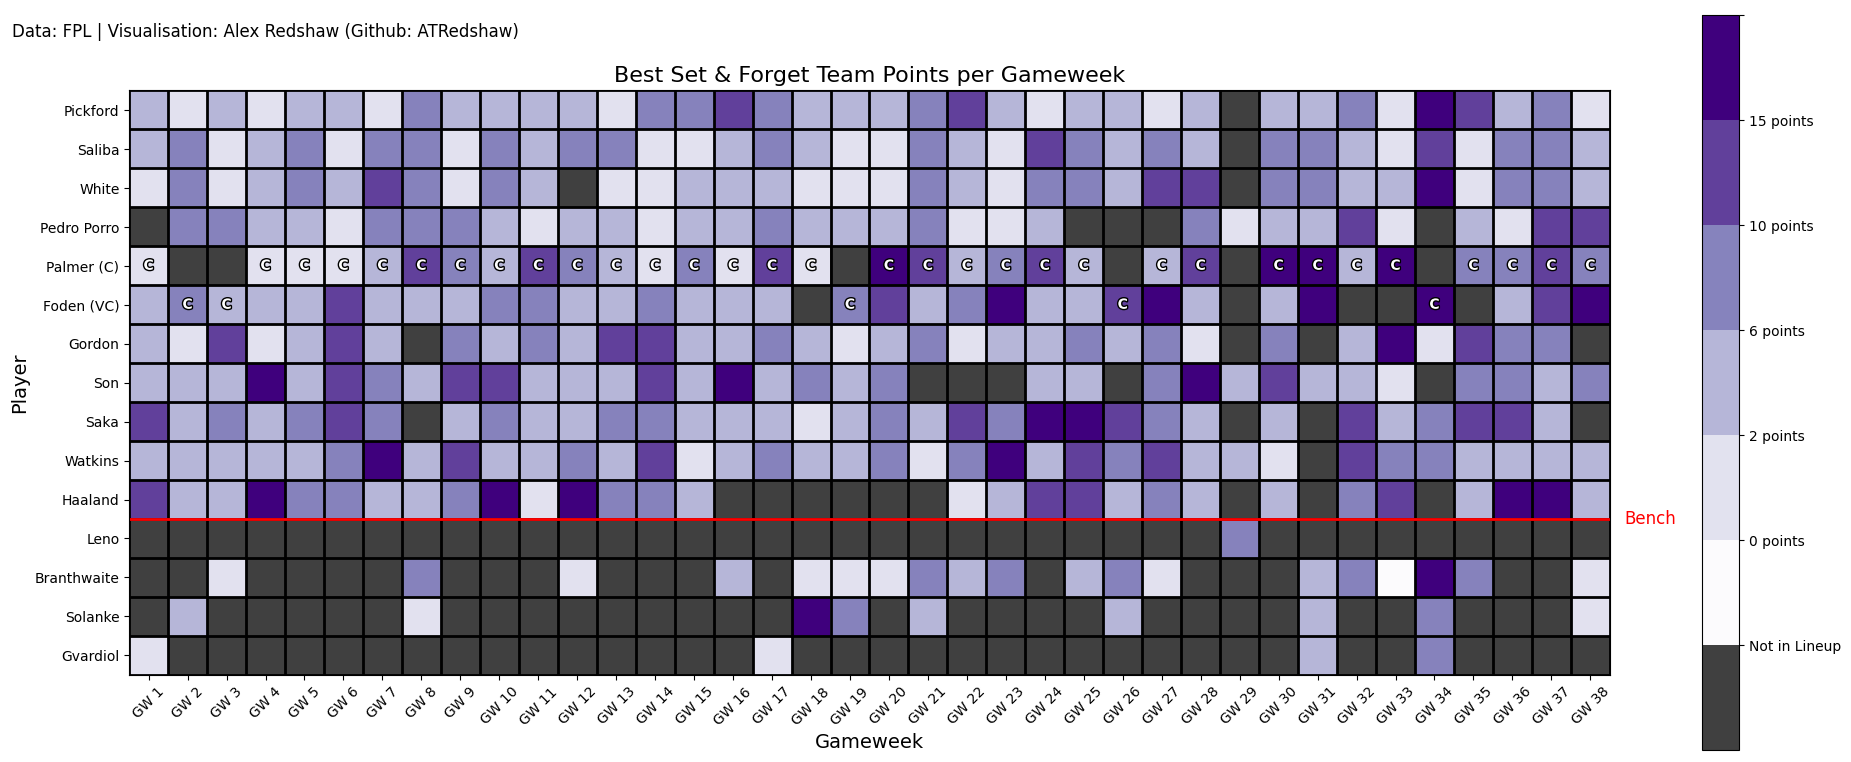

In [111]:
def add_captaincy_vice_captaincy_to_web_name(df):
    """
    Adds the captaincy and vice captaincy to the web_name column

    Args:
        df (pd.DataFrame): The dataframe to add the captaincy and vice captaincy to.

    Returns:
        pd.DataFrame: The dataframe with the captaincy and vice captaincy added to the web_name column.
    """
    # If the row is true for 'is_captain' append (C) to the web_name, if true for 'is_vice_captain' append (VC) to the web_name.
    df['web_name'] = df.apply(lambda row: row['web_name'] + ' (C)' if row['is_captain'] else row['web_name'], axis=1)
    df['web_name'] = df.apply(lambda row: row['web_name'] + ' (VC)' if row['is_vice_captain'] else row['web_name'], axis=1)
    return df

def visualise_player_point_breakdown(df):
    """
    Visualises the breakdown of player points across all of the gameweeks

    Args:
        df (pd.DataFrame): The dataframe to visualise.

    Returns:
        None
    """
    # Get current gameweek
    current_gw = get_current_gameweek(get_fpl_data())
    
    # Define bins and colors
    bins = [-99, -10, 0, 2, 6, 10, 15, np.inf]
    colors = plt.cm.Purples(np.linspace(0, 1, 6)).tolist()
    black = mcolors.to_rgba('#000000', alpha=0.75)
    colors = [black] + colors

    # Define bin labels
    bin_labels = ['Not in Lineup', '0 points', '2 points', '6 points', '10 points', '15 points', ' ']

    # Create a matrix to hold the values for the grid
    grid_data = np.full((len(df), current_gw), -100)

    # Fill the matrix with the player's points for each game week
    for i, row in df.iterrows():
        for j in range(1, current_gw + 1):
            gw_points_col = f"gw_{j}_points"
            gw_minutes_col = f"gw_{j}_minutes"
            gw_in_team_col = f"gw_{j}_in_team"
            if row[gw_in_team_col] and pd.notnull(row[gw_points_col]) and row[gw_minutes_col] > 0:
                points = row[gw_points_col]
                bin_index = np.digitize(points, bins) -2
                grid_data[i, j-1] = bin_index

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a colormap from the colors
    cmap = plt.cm.colors.ListedColormap(colors)
    
    # Plot the grid using imshow
    im = ax.imshow(grid_data, cmap=cmap, vmin=-1, vmax=len(bins)-2) 

    # Add a colorbar with the bin labels
    cbar = plt.colorbar(im, ax=ax, ticks=np.arange(len(colors)))
    cbar.ax.set_yticklabels(bin_labels)

    # Set the title and labels
    ax.set_title("Best Set & Forget Team Points per Gameweek", fontsize=16)
    ax.set_xlabel("Gameweek", fontsize=14)
    ax.set_ylabel("Player", fontsize=14)

    # Add tick marks and labels for players
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['web_name'], fontsize=10)

    # Add tick marks and labels for game weeks
    ax.set_xticks(np.arange(current_gw))
    ax.set_xticklabels([f"GW {i+1}" for i in range(current_gw)], fontsize=10, rotation=45)

    # Add a solid red line between the bench players and the lineup players
    bench_start = df[df['in_lineup'] == False].index[0]
    ax.axhline(bench_start - 0.5, color='red', linewidth=2)
    # Add 'Bench' at the end of the line on the right
    ax.text(current_gw + 1.2, bench_start - 0.5, 'Bench', ha='right', va='center', color='red', fontsize=12)

    # Add 'C' for captain's cells and vice-captain's cells where captain didn't play
    for i, row in df.iterrows():
        for j in range(1, current_gw + 1):
            gw_in_team_col = f"gw_{j}_in_team"
            gw_points_col = f"gw_{j}_points"
            gw_minutes_col = f"gw_{j}_minutes"
            if row[gw_in_team_col] and pd.notnull(row[gw_points_col]) and row[gw_minutes_col] > 0:
                if row['is_captain']:
                    text = ax.text(j-1, i, 'C', ha='center', va='center', color='w', fontweight='bold')
                    text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
                elif row['is_vice_captain'] and not df.loc[df['is_captain'], gw_in_team_col].any():
                    text = ax.text(j-1, i, 'C', ha='center', va='center', color='w', fontweight='bold')
                    text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

    ax.set_xticks(np.arange(-0.5, current_gw, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(df), 1), minor=True)
    ax.grid(which='minor', color='black', linewidth=2)
    ax.tick_params(which='minor', size=0)

    plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9)

    # Set fig size
    fig.set_size_inches(20, 8)
    plt.tight_layout()

    # Add plot caption
    ax.text(3, -2, "Data: FPL | Visualisation: Alex Redshaw (Github: ATRedshaw)", ha='center', va='center', fontsize=12)
    
    # Save the figure
    plt.savefig(f'visualisations/{year}/set_and_forget_player_point_breakdown.png', dpi=300)

    # Display the plot
    plt.show()

# Call the function using the engineered dataframe
visualise_player_point_breakdown(add_captaincy_vice_captaincy_to_web_name(engineered_df))

In [112]:
def did_captain_play(gw, df):
    return df.loc[df['is_captain'], f'gw_{gw}_in_team'].any()

player_totals_df = convert_history_to_df(team_df, simulated_team_season)   
current_gw = get_current_gameweek(get_fpl_data())

total_player_points_contribution = {}
for i, row in player_totals_df.iterrows():
    
    player_gameweek_breakdown = {}
    for j in range(1, current_gw + 1):
        points_scored = row[f'gw_{j}_points']
        point_scored_for_team = 0
        if row[f'gw_{j}_in_team']:
            point_scored_for_team = points_scored
        
        was_captain = False

        if row['is_captain'] and row[f'gw_{j}_in_team']:
            was_captain = True
        elif row['is_vice_captain'] and row[f'gw_{j}_in_team']:
            if not did_captain_play(j, player_totals_df):
                was_captain = True

        player_gameweek_breakdown[j] = {
            'points_scored': points_scored,
            'points_scored_for_team': point_scored_for_team,
            'in_final_team': row[f'gw_{j}_in_team'],
            'was_captain': was_captain
        }

    individual_player_contribution_dic = {
        'web_name': row['web_name'],
        'position': row['positions'],
        'gameweek_breakdown' : player_gameweek_breakdown
    }

    total_player_points_contribution[row['id']] = individual_player_contribution_dic

print(total_player_points_contribution)

with open(f'optimal_teams/json_representations/player_gameweek_contributions_{year}.json', 'w') as f:
    json.dump(total_player_points_contribution, f, indent=4)

{263: {'web_name': 'Pickford', 'position': 'GK', 'gameweek_breakdown': {1: {'points_scored': 2, 'points_scored_for_team': 2, 'in_final_team': True, 'was_captain': False}, 2: {'points_scored': 0, 'points_scored_for_team': 0, 'in_final_team': True, 'was_captain': False}, 3: {'points_scored': 2, 'points_scored_for_team': 2, 'in_final_team': True, 'was_captain': False}, 4: {'points_scored': 1, 'points_scored_for_team': 1, 'in_final_team': True, 'was_captain': False}, 5: {'points_scored': 3, 'points_scored_for_team': 3, 'in_final_team': True, 'was_captain': False}, 6: {'points_scored': 2, 'points_scored_for_team': 2, 'in_final_team': True, 'was_captain': False}, 7: {'points_scored': 1, 'points_scored_for_team': 1, 'in_final_team': True, 'was_captain': False}, 8: {'points_scored': 9, 'points_scored_for_team': 9, 'in_final_team': True, 'was_captain': False}, 9: {'points_scored': 2, 'points_scored_for_team': 2, 'in_final_team': True, 'was_captain': False}, 10: {'points_scored': 5, 'points_scor

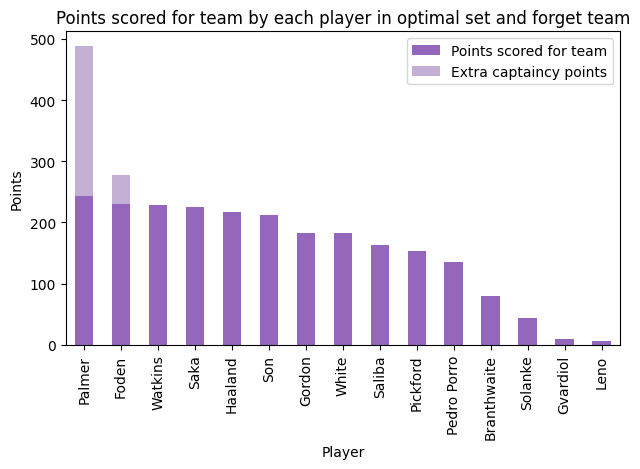

In [113]:
def convert_id_to_web_name(id, df=player_totals_df):
    return df.loc[df['id'] == id, 'web_name'].values[0]

# Plot the total points contribution (points_scored_for_team) by each player as a bar chart (ordered descendingly)
player_total_scored = {}
for key, value in total_player_points_contribution.items():
    points_scored_dic = {
        'points_scored_for_team': sum([x['points_scored_for_team'] for x in value['gameweek_breakdown'].values()]),
        'additional_captain_points': sum([x['points_scored_for_team'] for x in value['gameweek_breakdown'].values() if x['was_captain']])
    }

    player_total_scored[key] = points_scored_dic

sorted_player_totals = pd.DataFrame.from_dict(player_total_scored, orient='index')
sorted_player_totals['player_name'] = sorted_player_totals.index.map(lambda x: convert_id_to_web_name(x))

# Sort the DataFrame by 'points_scored_for_team' before plotting
sorted_player_totals = sorted_player_totals.sort_values(by='points_scored_for_team', ascending=False)  

# Plot the stacked barchart
fig, ax = plt.subplots()
sorted_player_totals[['points_scored_for_team', 'additional_captain_points']].plot(kind='bar', stacked=True, ax=ax, color=['#9467bd', '#c5b0d5']) 

ax.set_ylabel('Points')
ax.set_xlabel('Player')

# Set player names as x-axis labels (now using the sorted DataFrame)
ax.set_xticklabels(sorted_player_totals['player_name'], rotation=90)

# Add legend
ax.legend(['Points scored for team', 'Extra captaincy points'], loc='upper right')

# Add plot title
ax.set_title(f'Points scored for team by each player in optimal set and forget team')

plt.tight_layout()

# Save the figure (optional)
plt.savefig(f'visualisations/{year}/set_and_forget_total_team_points_contribution.png', dpi=300)

# Display the plot
plt.show()